# Linear Regression Assumptions

Delving into 4 assumptions neccessary for multivariable linear regression models.  Primarily this is done through the exploration of an Ad dataset.  Following the assumptions, an exercise in alleviating some of these issues is attempted.

In [1]:
import math
import warnings

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Supressing an annoying, harmless error.
warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='^internal gelsd')

In [4]:
# Creating a multivariable linear regression using a toy ad dataset
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instatiate and fit the model
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV', 'Radio', 'Newspaper']]
regr.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared: 
 0.8972106381789521


This model explains ~90% of the variance in Sales.  There is a base rate of sales which happen without any influence of the ads (2.939).  Radio ads have the highest per-unit increase of all ad types.

## Assumptions of multivariable linear regression

1. Linear relationship
2. Multivariate normality
3. Homoscedasticity
4. Low multicollinearity

#### Linear relationship assumption

Models will only search for linear trends.  If a non-linear trend exists, poor model fit will result.  Potentially alliveated by applying a non-linear transformation function to a feature - such as taking the sqrt of a quadratic variable.

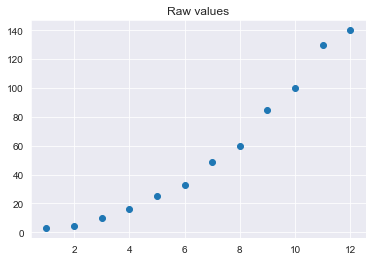

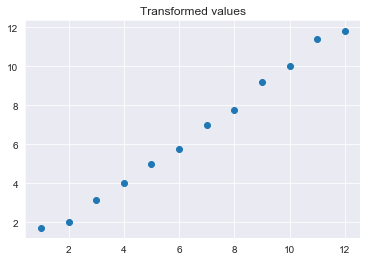

In [10]:
# Sample pseudo-quadratic data
outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
feature = [3, 4, 10, 16, 25, 33, 49, 60, 85, 100, 130, 140]

sns.set_style('darkgrid')
plt.scatter(outcome, feature)
plt.title('Raw values')
plt.show()

# Applying a non-linear transform to the feature
sqrt_feature = [math.sqrt(x) for x in feature]

plt.scatter(outcome, sqrt_feature)
plt.title('Transformed values')
plt.show()

Need to be mindful of interpreting results when features have non-linear transformations!

#### Multivariate normality

The model error (difference of model-predicted values from the real outcomes) should be normally distributed.  Skewness or outliers in the error, which are usually caused by outliers or skew in the data, can cause serious degredation of modeled results.

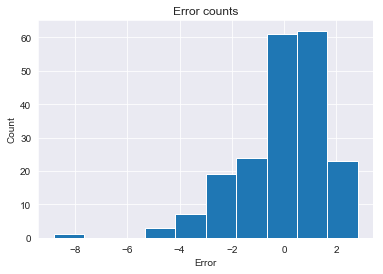

In [12]:
# Calculating the error for the sales model
predicted = regr.predict(X).ravel()
actual = data['Sales']

error = actual - predicted

plt.hist(error)
plt.title('Error counts')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

Error (residual) is right-skewed.

#### Homoscedasticity

The distribution of the error terms (it's "scedasticity"), should be consistent for all predicted values, or **homoscedastic**.

If the error terms aren't consistently distributed and have more variance in the error for large outcome values than small ones, then the confidence interval for large predicted values will be too small.  This leads to overconfidence in the accuracy of the model's prediction

Potential remidiations include transforming the dependent variable and adding features which target the poorly-estimated areas.

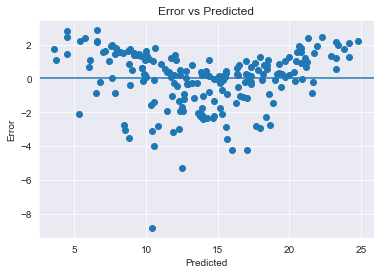

In [13]:
plt.scatter(predicted, error)
plt.xlabel('Predicted')
plt.ylabel('Error')
plt.axhline(y=0)
plt.title('Error vs Predicted')
plt.show()

Error values are not normally distributed - not homoscedastic.

#### Low multicollinearity

Correlations between features should be low or non-existent.  Not really an issue if the only goal is prediction.  But if we want to understand which features matter most, multicollinearity will cause an underestimation of the relationship between features and outcomes.  This is because, with correlated variables, the model may attempt to attribute half the explanatory power of one feature and half to the other.

Multicollinearity can be fixed by PCA or removing some correlated features.

In [14]:
display(X.corr())

,TV,Radio,Newspaper
TV,1.000,0.055,0.057
Radio,0.055,1.000,0.354
Newspaper,0.057,0.354,1.000


# Attempting to engineer a data fix

Based on these diagnostic plots, the data has an issue with heteroscedasticity and multivariate non-normality.  Trying to fix these problems below:

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


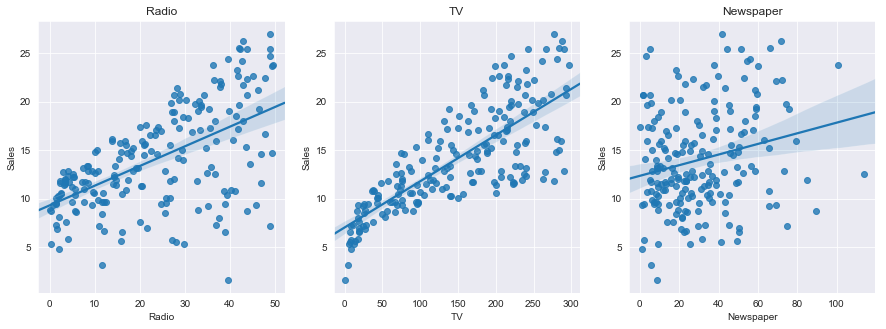

In [23]:
# Plotting all three variables vs. sales.

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.regplot(data=data, x='Radio', y='Sales')
plt.title('Radio')

plt.subplot(1,3,2)
sns.regplot(data=data, x='TV', y='Sales')
plt.title('TV')

plt.subplot(1,3,3)
sns.regplot(data=data, x='Newspaper', y='Sales')
plt.title('Newspaper')
plt.show()

The Radio data appear to have an upper bound and a large tail towards the low end. I'm not entirely sure how best to fix this issue. TV data appear to be a sqrt function.  Newspaper sales data, while scattered enough that it shouldn't matter, is moderately correlated with the Radio data. Therefore we will drop it from the model.

In [21]:
data['TV_sqrt'] = data['TV'].apply(lambda x: math.sqrt(x))

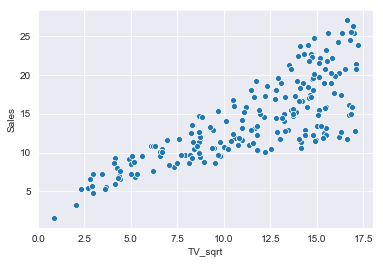

In [22]:
sns.scatterplot(data=data, x='TV_sqrt', y='Sales')
plt.show()

In [31]:
# Instantiating Model 2
regr2 = linear_model.LinearRegression()
X2 = data[['Radio', 'TV_sqrt']]
Y2 = Y
regr2.fit(X2, Y2)

print('\nCoefficients: \n', regr2.coef_)
print('\nIntercept: \n', regr2.intercept_)
print('\nR-squared: \n', regr2.score(X2, Y2))


Coefficients: 
 [[0.1944958  0.97485384]]

Intercept: 
 [-1.617931]

R-squared: 
 0.9289507061869382


The model performs slightly better than the previous version. R^2 = 0.92 vs. R^2 = 0.89.

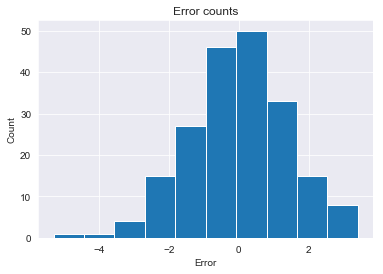

In [28]:
# Calculating the error for sales model 2
predicted2 = regr2.predict(X2).ravel()
actual2 = data['Sales']

error2 = actual2 - predicted2

plt.hist(error2)
plt.title('Error counts')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

Good! That's a normal distribution.

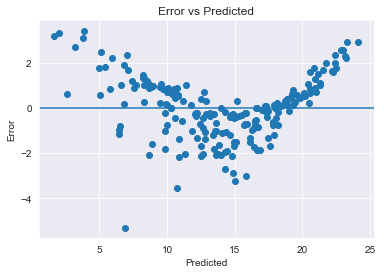

In [29]:
# Plotting the scedasticity

plt.scatter(predicted2, error2)
plt.xlabel('Predicted')
plt.ylabel('Error')
plt.axhline(y=0)
plt.title('Error vs Predicted')
plt.show()

Eh...that looks worse than the previous model.  Need attempt to fix the spread of Radio and TV data at high values.

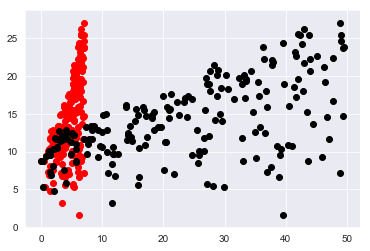

In [54]:
data['Radio_sqrt'] = data['Radio'].apply(lambda x: math.sqrt(x))
plt.scatter(data['Radio_sqrt'], data['Sales'], color='r')
plt.scatter(data['Radio'], data['Sales'], color='k')
plt.show()

In [55]:
# Instantiating Model 3
regr3 = linear_model.LinearRegression()
X3 = data[['Radio_sqrt', 'TV_sqrt']]
Y3 = Y
regr3.fit(X3, Y3)

print('\nCoefficients: \n', regr3.coef_)
print('\nIntercept: \n', regr3.intercept_)
print('\nR-squared: \n', regr3.score(X3, Y3))


Coefficients: 
 [[1.57163139 0.96845657]]

Intercept: 
 [-4.07185967]

R-squared: 
 0.9081027926847713


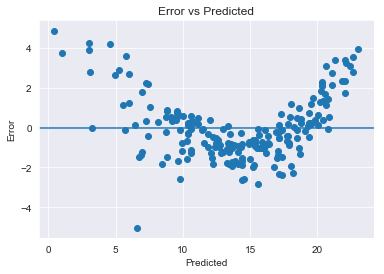

In [56]:
# Plotting the scedasticity
predicted3 = regr3.predict(X3).ravel()
actual3 = data['Sales']
error3 = actual3 - predicted3

plt.scatter(predicted3, error3)
plt.xlabel('Predicted')
plt.ylabel('Error')
plt.axhline(y=0)
plt.title('Error vs Predicted')
plt.show()

That's an even poorer scedasticity...